# Pyspatialml
## Example Classification

Here we are going to perform a simple classification of landsat data, using training points that were created from a previous year's classification. The data for this example is derived from the GRASS GIS North Carolina Example Dataset.

In [31]:
from osgeo import gdal
from pyspatialml.sampling import extract
from pyspatialml import predict
import geopandas as gpd
import rasterio
from rasterio import plot
from rasterio.sample import sample_gen
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Raster data as single bands, and training points as a shapefile:

In [28]:
band1 = 'lsat7_2000_10.tif'
band2 = 'lsat7_2000_20.tif'
band3 = 'lsat7_2000_30.tif'
band4 = 'lsat7_2000_40.tif'
band5 = 'lsat7_2000_50.tif'
band7 = 'lsat7_2000_70.tif'
training_points = 'landclass96_roi.shp'

We are going to use a GDAL VRT (Virtual Tile Format) to 'stack' the bands without physically making a copy of the data:

In [33]:
predictors = [band1, band2, band3, band4, band5, band7]
vrt_file = 'landsat.vrt'
outds = gdal.BuildVRT(
    destName=vrt_file, srcDSOrSrcDSTab=predictors, separate=True,
    resolution='highest', resampleAlg='bilinear')
outds.FlushCache()

Read the training data as a geopandas dataframe:

In [30]:
# read vector data
training_gpd = gpd.read_file(training_points)

Show training data and a single raster band:

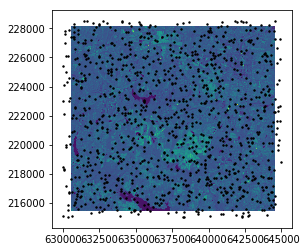

In [40]:
# plotting
src = rasterio.open(vrt_file)
srr_arr = src.read(4, masked=True)
plt.imshow(srr_arr, extent=(bounds.left, bounds.right, bounds.bottom, bounds.top))
plt.scatter(x=training_gpd.bounds.iloc[:, 0], y=training_gpd.bounds.iloc[:, 1],
            s=2, color='black')
plt.show()
src.close()

Extracting training data from locations of geopandas array:

In [35]:
# extract using pyspatialml
X, y, xy = extract(raster=vrt_file, response_gdf=training_gpd, field='id')

# otherwise extract using rasterio sample_gen
coordinates = training_gpd.bounds.iloc[:, 0:2].as_matrix()
with rasterio.open(vrt_file) as src:
    X = np.vstack([i for i in sample_gen(src, coordinates)])
X = np.ma.masked_equal(X, src.nodatavals)
y = training_gpd.id
y = np.ma.masked_array(y, mask=X.mask.any(axis=1), fill_value=-99999)


Get valid entries only to pass to the classifier

In [36]:
X = X[~X.mask.any(axis=1)]
y = y[~y.mask]

Training model:

In [37]:
# classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X, y)
scores = cross_validate(clf, X, y, cv=3, scoring=['accuracy'])
scores['test_accuracy'].mean()

0.6463579620576207

Prediction on raster vrt file:

In [38]:
result = predict(estimator=clf, raster=vrt_file, file_path='classification.tif')

Plotting of results:

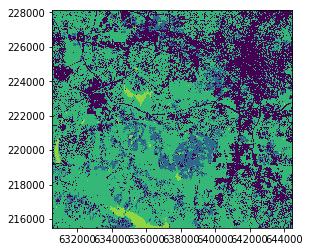

In [39]:
result = rasterio.open('classification.tif')
rasterio.plot.show(result)
result.close()